In [1]:
import pandas as pd
import matplotlib

dataset = pd.read_csv('../Datasets/La myriade de Totems de Montpellier - SaisiesFormulaire (4).csv')
dataset.rename(columns={"Heure / Time": "Time", "Vélos depuis le 1er janvier / Grand total": "Y_Total",
                                  "Vélos ce jour / Today's total": "D_Total"},inplace=True)
dataset.drop(['Unnamed: 4', 'Remarque'],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [110]:
dataset = pd.read_csv('../Datasets/Dataset_processed.csv')
data = dataset[0:7]
dataset['D_Total'].mean()
# data.plot(x="Date",y="D_Total")

2392.3196721311474

In [5]:
dataset_meteo = pd.read_csv('../Datasets/export-montpellier2020.csv')

In [1]:
from datetime import datetime

import pandas as pd
import matplotlib
import tqdm as tqdm

final_dataset = pd.DataFrame(columns=['Date','Y_Total','D_Total'])

dataset = pd.read_csv('../Datasets/La myriade de Totems de Montpellier - SaisiesFormulaire (4).csv')
dataset_meteo = pd.read_csv('../Datasets/export-montpellier2020.csv')

dataset.rename(columns={"Heure / Time": "Time", "Vélos depuis le 1er janvier / Grand total": "Y_Total",
                                  "Vélos ce jour / Today's total": "D_Total"},inplace=True)
dataset.drop(['Unnamed: 4', 'Remarque'],axis=1,inplace=True)
dataset.dropna(inplace=True)

for j,day in dataset.iterrows():
    dataset['Date'].loc[j] = datetime.strptime(day['Date'],"%d/%m/%Y")
for j, day in dataset_meteo.iterrows():
    dataset_meteo['DATE'].loc[j] = datetime.strptime(day['DATE'], "%Y-%m-%d")

date_range = pd.date_range(start=dataset['Date'].iloc[0],
                               end=dataset['Date'].iloc[-1])
#cumuler les données d'une journée en une seule data


for date in date_range:
    df = dataset[dataset['Date'] == date]
    Y_total = 0
    D_total = 0
    for i, days in df.iterrows():
         D_total = D_total + days['D_Total']
         Y_total = Y_total + days['Y_Total']
    final_dataset = final_dataset.append({'Date':date,'Y_Total':Y_total,'D_Total':D_total},ignore_index=True)


final_dataset.to_csv('../Datasets/Dataset_processed.csv',index=False,header=True)

final_dataset.set_index('Date',inplace=True)
dataset_meteo.set_index('DATE',inplace=True)

df = pd.concat([final_dataset,dataset_meteo],axis=1,join='inner')
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'},inplace=True)



c:\users\franc\pycharmprojects\mtpbicycle\venv\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


          Date   Y_Total  D_Total  MAX_TEMPERATURE_C  MIN_TEMPERATURE_C  WINDSPEED_MAX_KMH  TEMPERATURE_MORNING_C  TEMPERATURE_NOON_C  TEMPERATURE_EVENING_C  PRECIP_TOTAL_DAY_MM  HUMIDITY_MAX_PERCENT  VISIBILITY_AVG_KM  PRESSURE_MAX_MB  CLOUDCOVER_AVG_PERCENT  HEATINDEX_MAX_C  DEWPOINT_MAX_C  WINDTEMP_MAX_C  WEATHER_CODE_MORNING  WEATHER_CODE_NOON  WEATHER_CODE_EVENING  TOTAL_SNOW_MM  UV_INDEX  SUNHOUR                 OPINION
285 2020-12-22  969938.0    671.0                 16                 11                  8                     11                  15                     15                  0.0                    81             10.000             1027                   6.750               16              12              10                   116                116                   116              0         4      8.7          météo correcte
286 2020-12-23  324478.0    496.0                 13                 12                 19                     12                  13       

<AxesSubplot:xlabel='Date'>

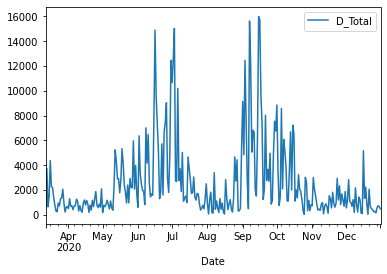

In [2]:
df.plot(x="Date",y="D_Total")

<AxesSubplot:xlabel='Date'>

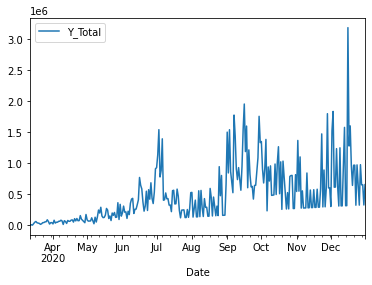

In [3]:
df
df.plot(x="Date",y="Y_Total")

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

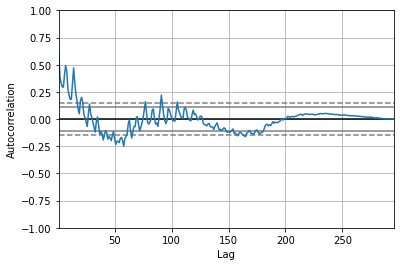

In [5]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['D_Total'])

<AxesSubplot:ylabel='D_Total'>

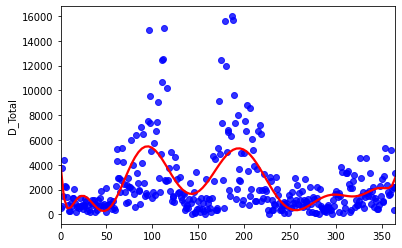

In [33]:
import seaborn as sns
df = pd.read_csv('../Datasets/Dataset_processed.csv')
sns.regplot(x=df.index, y=df['D_Total'],
                scatter_kws={"color": "blue"}, line_kws={"color": "red"},
                 order=12, ci=None)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

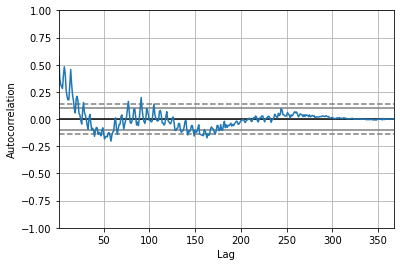

In [25]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['D_Total'])

In [34]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 

# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df['D_Total'], p_values, d_values, q_values)

c:\users\franc\pycharmprojects\mtpbicycle\venv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


Best ARIMANone RMSE=inf


In [35]:
date_range_2 = pd.date_range(start=datetime.strptime('2020-07-01', "%Y-%m-%d"),
                               end=datetime.strptime('2020-08-30', "%Y-%m-%d"))

print(type(date_range_2))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [37]:
hollidayList = []
for date in date_range_2:
        hollidayList.append({'Date': date, 'hollyday': 1})

hollyday_df = pd.DataFrame(hollidayList)
print(hollyday_df.to_string())

         Date  hollyday
0  2020-07-01         1
1  2020-07-02         1
2  2020-07-03         1
3  2020-07-04         1
4  2020-07-05         1
5  2020-07-06         1
6  2020-07-07         1
7  2020-07-08         1
8  2020-07-09         1
9  2020-07-10         1
10 2020-07-11         1
11 2020-07-12         1
12 2020-07-13         1
13 2020-07-14         1
14 2020-07-15         1
15 2020-07-16         1
16 2020-07-17         1
17 2020-07-18         1
18 2020-07-19         1
19 2020-07-20         1
20 2020-07-21         1
21 2020-07-22         1
22 2020-07-23         1
23 2020-07-24         1
24 2020-07-25         1
25 2020-07-26         1
26 2020-07-27         1
27 2020-07-28         1
28 2020-07-29         1
29 2020-07-30         1
30 2020-07-31         1
31 2020-08-01         1
32 2020-08-02         1
33 2020-08-03         1
34 2020-08-04         1
35 2020-08-05         1
36 2020-08-06         1
37 2020-08-07         1
38 2020-08-08         1
39 2020-08-09         1
40 2020-08-10   

In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

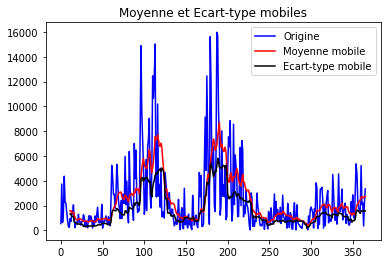

In [8]:
import pandas as pd
from matplotlib import pyplot as plt
dataset = pd.read_csv('../Datasets/Dataset_processed.csv')
df = dataset['D_Total']
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.plot(df, color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df)
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : -2.3208093583087286
p-value : 0.16534434204894144
Valeurs Critiques :
	1%: -3.44911857009962
	5%: -2.8698097654570507
	10%: -2.5711757061225153


In [19]:
def get_stationarity(timeseries):
    
    # Statistiques mobiles
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # tracé statistiques mobiles
    original = plt.plot(timeseries, color='blue', label='Origine')
    mean = plt.plot(rolling_mean, color='red', label='Moyenne Mobile')
    std = plt.plot(rolling_std, color='black', label='Ecart-type Mobile')
    plt.legend(loc='best')
    plt.title('Moyenne et écart-type Mobiles')
    plt.show(block=False)
    
    # Test Dickey–Fuller :
    result = adfuller(timeseries)
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

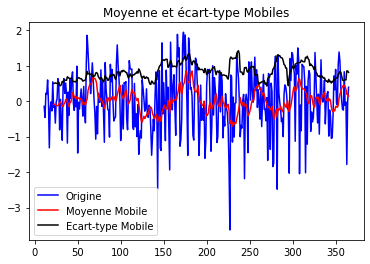

Statistiques ADF : -3.8787573005888167
p-value : 0.002196864444037774
Valeurs Critiques :
	1%: -3.449673193310592
	5%: -2.8700533746644323
	10%: -2.5713055939491403


In [20]:
import numpy as np
df_log = np.log(df)
rolling_mean = df_log.rolling(window=12).mean()

df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

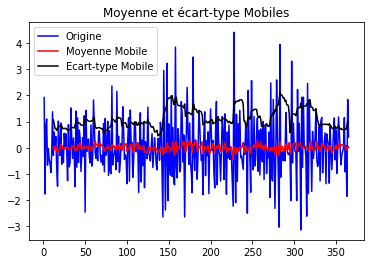

Statistiques ADF : -6.703963218476153
p-value : 3.8266088699126175e-09
Valeurs Critiques :
	1%: -3.44911857009962
	5%: -2.8698097654570507
	10%: -2.5711757061225153


In [25]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)

get_stationarity(df_log_shift)

In [58]:
order = (2, 0 ,0)


1.1019947630819307

<AxesSubplot:>

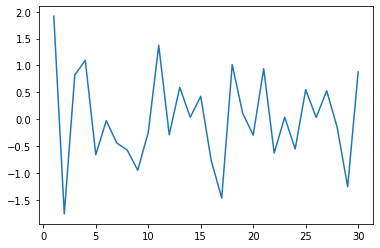

In [78]:
df_log_shift[:30].plot()

In [75]:
 rmse = sqrt(mean_squared_error(df['D_Total'][-len(prediction):], np.zeros(len(prediction))))  
print(rmse)

1.1302023381051984


In [113]:
from numpy.linalg import LinAlgError
from statsmodels.tsa.arima.model import SARIMAXSpecification
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
#decomposition = seasonal_decompose(df_log) 
for i in range(4):
    for k in range(4):
        order = (i, 0, k)
        model = ARIMA(df['D_Total'], order=order)
        try:
            results = model.fit(disp=-1)
            prediction = results.predict(dynamic=True)
            rmse = sqrt(mean_squared_error(df['D_Total'][-len(prediction):], prediction))  
            
            
            print('Test RMSE: %.3f' % rmse)
        except ValueError:
            print("Invalid order =", order)
        except LinAlgError:
            print("SVD error order =", order)
#             plt.plot(df)
#             plt.plot(results.fittedvalues, color='red')

Test RMSE: 2807.464
Test RMSE: 2807.051
Test RMSE: 2806.591
Test RMSE: 2807.083
Test RMSE: 2811.050
Test RMSE: 2810.707
Invalid order = (1, 0, 2)
Invalid order = (1, 0, 3)
Test RMSE: 2814.744
Test RMSE: 2811.343
Test RMSE: 2815.129
Invalid order = (2, 0, 3)
Test RMSE: 2814.620
Test RMSE: 2807.032
Test RMSE: 2811.377
Test RMSE: 2807.356


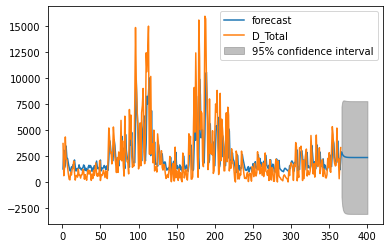

In [37]:
fig = results.plot_predict(1,400)

In [89]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

df = pd.read_csv('../Datasets/Dataset_clean.csv')
df['hollyday'] = df['hollyday'].replace(0.4, 0)
columns = [column for column in df if column not in
           ['Date', 'Y_Total', 'D_Total']]
X = df[columns]
y = df['D_Total']

pipeline = Pipeline([('poly_features', PolynomialFeatures(degree=2)),
                     ('ols', LinearRegression())])
pipeline.fit(X, y)
print(type(X.iloc[0]))
100 * r2_score(y, pipeline.predict(X))

np.sqrt(mean_squared_error(y, pipeline.predict(X)))

pipeline[0].get_feature_names() # features name
pipeline[1].coef_ # coefficients

<class 'pandas.core.series.Series'>


array([-4.05553263e-09, -1.41494646e+02, -7.08387661e+02,  3.33407862e+02,
       -4.37555676e+02, -1.24805669e+02, -1.25746228e+02,  9.26383784e+02,
       -1.40144604e+02, -1.44078236e+03,  6.11448974e+03, -1.88648674e+02,
       -1.87809794e+03,  2.75018027e+00, -3.32640455e+01,  5.10745918e+01,
        2.13704255e+01,  4.16853161e+02,  1.51994415e+03,  8.46591328e+01,
        2.14635905e+03, -2.79087838e+02,  2.83389190e+01, -7.39963982e+01,
        4.51493584e+01, -1.59282527e+01,  1.77298949e+03,  5.39369453e+02,
       -1.88043511e+00,  2.67095350e+02,  8.19685889e-02, -1.68278850e+00,
       -4.04927255e+00,  6.55708603e-02, -1.47621387e+01, -9.41349314e+00,
       -8.32625554e+00,  3.63696927e+01,  5.09282583e+00,  6.81106350e+00,
        1.38643436e+00,  3.66731752e+01,  4.50229336e+01, -3.97853017e+00,
        1.50494507e+02,  1.29607467e+00, -9.63523007e-01, -7.70403998e+01,
       -1.61060277e+01,  6.83275190e+00,  1.40898729e+02,  9.32161507e-01,
       -7.04984193e+00,  

In [82]:
100 * r2_score(y, pipeline.predict(X))

39.70103090414899

In [84]:
np.sqrt(mean_squared_error(y, pipeline.predict(X)))

2180.0636271937747

In [86]:
X.iloc[0]

MAX_TEMPERATURE_C         17.0
MIN_TEMPERATURE_C         14.0
WINDSPEED_MAX_KMH         10.0
PRECIP_TOTAL_DAY_MM        0.1
HUMIDITY_MAX_PERCENT      80.0
CLOUDCOVER_AVG_PERCENT    28.0
HEATINDEX_MAX_C           17.0
WINDTEMP_MAX_C            13.0
SUNHOUR                   11.5
hollyday                   0.0
Name: 0, dtype: float64

In [104]:
test = {'MAX_TEMPERATURE_C':18,'MIN_TEMPERATURE_C':11,'WINDSPEED_MAX_KMH':45,'PRECIP_TOTAL_DAY_MM':0,'HUMIDITY_MAX_PERCENT':31,
        'CLOUDCOVER_AVG_PERCENT':12,'HEATINDEX_MAX_C':14,'WINDTEMP_MAX_C':13,'SUNHOUR':11.5,'Hollyday':0
}
input = pd.DataFrame(columns=['MAX_TEMPERATURE_C','MIN_TEMPERATURE_C','WINDSPEED_MAX_KMH','PRECIP_TOTAL_DAY_MM','HUMIDITY_MAX_PERCENT',
        'CLOUDCOVER_AVG_PERCENT','HEATINDEX_MAX_C','WINDTEMP_MAX_C','SUNHOUR','Hollyday'])
input = input.append(test,ignore_index=True)
input = input.append(test,ignore_index=True)


   MAX_TEMPERATURE_C  MIN_TEMPERATURE_C  WINDSPEED_MAX_KMH  PRECIP_TOTAL_DAY_MM  HUMIDITY_MAX_PERCENT  CLOUDCOVER_AVG_PERCENT  HEATINDEX_MAX_C  WINDTEMP_MAX_C  SUNHOUR  Hollyday
0               18.0               11.0               45.0                  0.0                  31.0                    12.0             14.0            13.0     11.5       0.0


In [105]:
pipeline.predict(input)

array([12071.85828177])

In [145]:
dataset = pd.read_csv('../Datasets/La myriade de Totems de Montpellier - SaisiesFormulaire (4).csv')
dataset.rename(columns={"Heure / Time": "Time", "Vélos depuis le 1er janvier / Grand total": "Y_Total",
                                  "Vélos ce jour / Today's total": "D_Total"},inplace=True)
dataset.drop(['Unnamed: 4', 'Remarque'],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [146]:
for i,data in dataset.iterrows():
    print(data['Time'].split(':')[0])
    dataset['Time'].loc[i] = int(data['Time'].split(':')[0])
print(type(dataset['Time'].iloc[0]))
dataset.to_csv('../Datasets/hour_dataset.csv',header= True,index=False)

11
14
10
14
18
18
16
09
09
11
14
15
20
06
08
08
11
17
18
18
21
22
08
08
08
10
11
11
11
12
15
19
08
12
19
19
20
22
07
13
19
19
19
08
15
18
19
12
20
10
15
18
08
14
15
17
19
07
09
17
18
19
08
16
18
18
18
19
07
16
19
19
20
20
08
16
17
17
17
17
17
18
19
08
13
16
19
19
19
15
20
08
13
15
18
08
10
19
19
18
19
08
12
13
14
16
18
19
09
17
19
11
14
18
19
10
12
17
22
06
08
11
17
19
08
11
12
13
18
08
12
13
17
18
20
08
11
17
18
19
18
09
11
16
18
20
10
12
12
18
12
18
07
10
11
19
19
13
18
19
20
08
11
14
20
09
09
14
19
20
09
11
12
20
21
10
11
20
12
14
16
16
18
19
07
12
18
20
13
14
15
18
20
21
08
11
11
19
12
14
20
20
09
12
12
14
19
20
20
21
11
13
13
15
21
06
11
12
18
10
18
21
11
20
08
11
13
15
16
18
19
20
05
06
07
14
09
13
21
11
16
19
09
13
19
07
09
13
14
17
08
11
19
18
09
09
12
19
22
11
18
08
10
15
18
20
06
10
10
13
13
19
20
20
21
08
11
19
20
20
21
21
05
05
11
12
16
18
18
18
19
20
09
14
18
19
19
13
16
19
21
10
13
16
23
06
13
17
21
22
06
11
12
17
18
19
20
22
04
04
09
12
18
19
22
06
21
23
06
11
19
20
07
2

In [140]:
# data_9 = dataset[dataset['Time']==9]['D_Total'].sum()
print(type(dataset['Time'].iloc[0]))
data_9 = dataset[dataset['Time']<9]
data_ = dataset[dataset['Time']>=9]
print(data_9)
before_9 = data_9['D_Total'].sum()
cycle = dataset['D_Total'].sum()
print(before_9/cycle)

<class 'int'>
            Date Time  Y_Total  D_Total
15    16/03/2020    6   5097.0     14.0
16    16/03/2020    8   5157.0     74.0
17    16/03/2020    8   5176.0     93.0
24    17/03/2020    8   6069.0     40.0
25    17/03/2020    8   6109.0     80.0
...          ...  ...      ...      ...
1316  19/02/2021    8  54053.0    158.0
1334  27/02/2021    6  61757.0     15.0
1354  04/03/2021    8  68660.0    187.0
1383  10/03/2021    6  76807.0     21.0
1392  12/03/2021    8  80500.0    175.0

[225 rows x 4 columns]
0.023564521931402398


In [142]:
12071*0.0236

284.8756